## Домашняя работа по теме "GAN (Generative Adversarial Networks)"

__Задание__

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
# import os
import numpy as np
import math
import torch
import torch.nn as nn
# import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
# from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from IPython import display
from torchvision.utils import save_image, make_grid

Построим график заданной функции

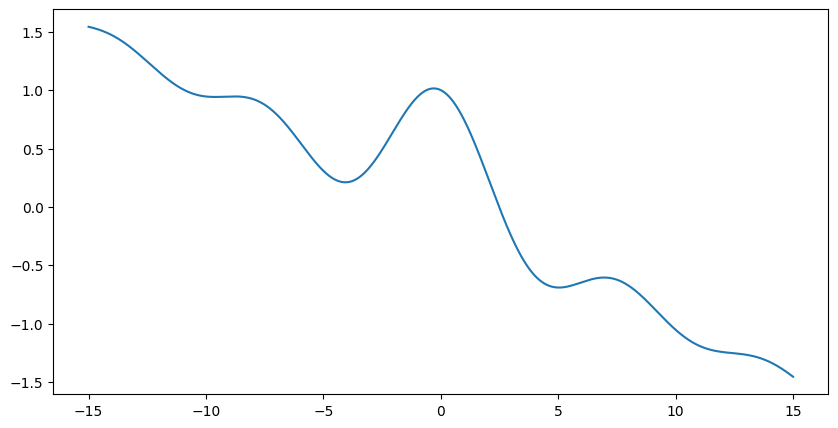

In [6]:
fig = plt.subplots(figsize=(10,5))

x = np.linspace(-15, 15,10000)

y = lambda x: (np.sin(x) / x) - (x/10) #- z
y_x = y(x) # чтобы каждый раз не считывать функцию

plt.plot(x, y(x))

plt.show()

Переведем точки с графика в тензоры:

In [7]:
train_data_length = 10000 
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.from_numpy(np.array(x))  # x
train_data[:, 1] = torch.from_numpy(np.array(y_x)) #  у

train_labels = torch.zeros(train_data_length) 

train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

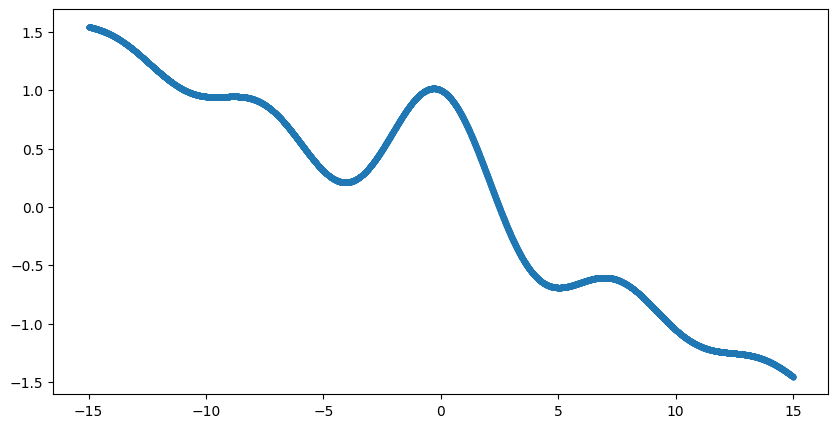

In [8]:
# отрисуем тензорные точки

fig = plt.subplots(figsize=(10,5))

plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [9]:
batch_size = 25
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()
generator = Generator()


In [11]:
lr = 0.001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
      
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.2061784416437149, Loss G.: 1.3533564805984497
Epoch: 10 Loss D.: 0.6575753092765808, Loss G.: 0.8303228616714478
Epoch: 20 Loss D.: 0.6942692399024963, Loss G.: 0.6917100548744202
Epoch: 30 Loss D.: 0.6231180429458618, Loss G.: 0.8149868845939636
Epoch: 40 Loss D.: 0.6269504427909851, Loss G.: 0.8148195743560791
Epoch: 50 Loss D.: 0.6145315766334534, Loss G.: 0.8348305225372314
Epoch: 60 Loss D.: 0.7016555666923523, Loss G.: 0.720990002155304
Epoch: 70 Loss D.: 0.6695159673690796, Loss G.: 0.7759177684783936
Epoch: 80 Loss D.: 0.6834408044815063, Loss G.: 0.8847213983535767
Epoch: 90 Loss D.: 0.6867101788520813, Loss G.: 0.7172375321388245


In [13]:
latent_space_samples = torch.randn(100, 2) 
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach() 

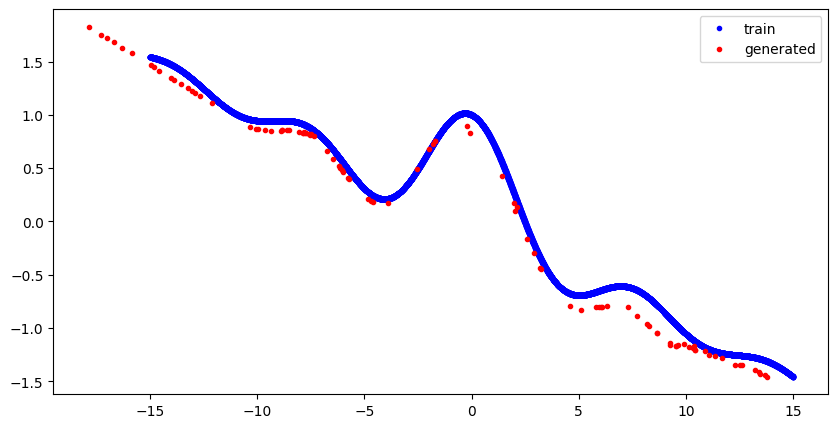

In [14]:
fig = plt.subplots(figsize=(10,5))
plt.plot(train_data[:, 0], train_data[:, 1], ".", color='blue', label='train')
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".", color='red', label='generated')
plt.legend()
plt.show()